In [1]:
pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'), 
    ('order_items.csv', 'order_items'),# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='7F*q&654',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/sabab/OneDrive/Desktop/ecommerce/archive'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db =mysql.connector.connect(host ="Localhost",username = "root", password = "7F*q&654",database = "ecommerce")
cur = db.cursor()


# List all unique cities where customers are located?¶

In [8]:
query = """ select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count the number of orders placed in 2017.

In [9]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017"""
cur.execute(query)
data = cur.fetchall()
"total orders places in 2017 are" , data

('total orders places in 2017 are', [(360808,)])

# Find the total sales per category.

In [3]:
query = """
select  upper(products.product_category) as category, round(sum(payments.payment_value), 2) as sales
from products 
join order_items on products.product_id = order_items.product_id
join payments on payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()
#print("Total sales per category are:", data)
df= pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,PERFUMERY,3.243127e+07
1,FURNITURE DECORATION,9.153129e+07
2,TELEPHONY,3.116045e+07
3,BED TABLE BATH,1.096034e+08
4,AUTOMOTIVE,5.454684e+07
...,...,...
69,CDS MUSIC DVDS,7.676352e+04
70,LA CUISINE,1.864659e+05
71,FASHION CHILDREN'S CLOTHING,5.028288e+04
72,PC GAMER,1.391635e+05


# Calculate the percentage of orders that were paid in installments.

In [14]:
query = """

SELECT ROUND(SUM(CASE WHEN payment_installments = 1 THEN 1 ELSE 0 END) / COUNT(*) * 100, 2) AS installment_percentage
FROM payments
"""
cur.execute(query)
data = cur.fetchall()
print("percentage of orders that were paid in installments is:", data[0][0])

percentage of orders that were paid in installments is: 50.58


# Count the number of customers from each state.

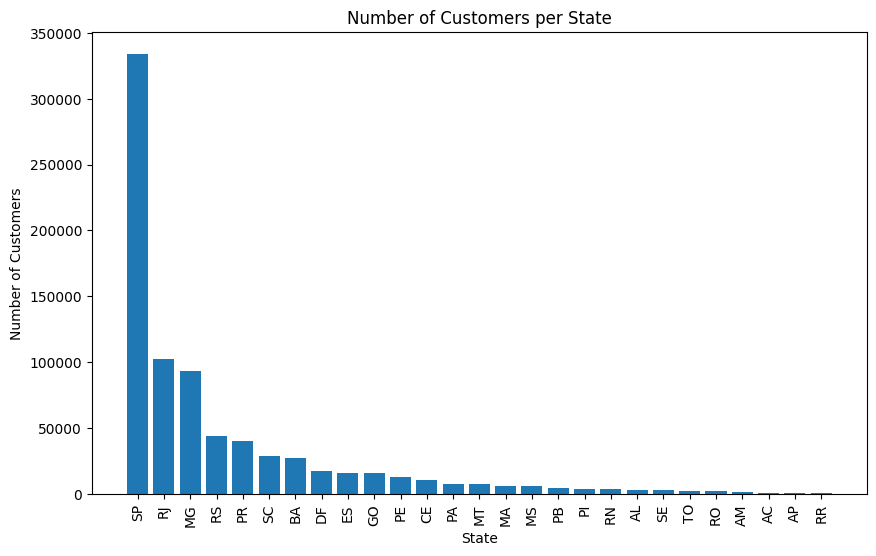

In [15]:
query = """
SELECT customer_state, COUNT(*) AS Customers_Count
FROM customers
GROUP BY customer_state
"""
cur.execute(query)
data = cur.fetchall()

# Creating DataFrame with the fetched data
df = pd.DataFrame(data, columns=["State", "Customers_Count"])
df = df.sort_values(by = "Customers_Count", ascending = False)
# Plotting the bar chart
plt.figure(figsize = (10,6))
plt.bar(df["State"], df["Customers_Count"])
plt.xlabel("State")
plt.ylabel("Number of Customers")
plt.title("Number of Customers per State")
plt.xticks(rotation=90)  # Rotate state labels for better readability
plt.savefig("customers_per_state.png", bbox_inches='tight')
plt.show()

# Calculate the number of orders per month in 2018.

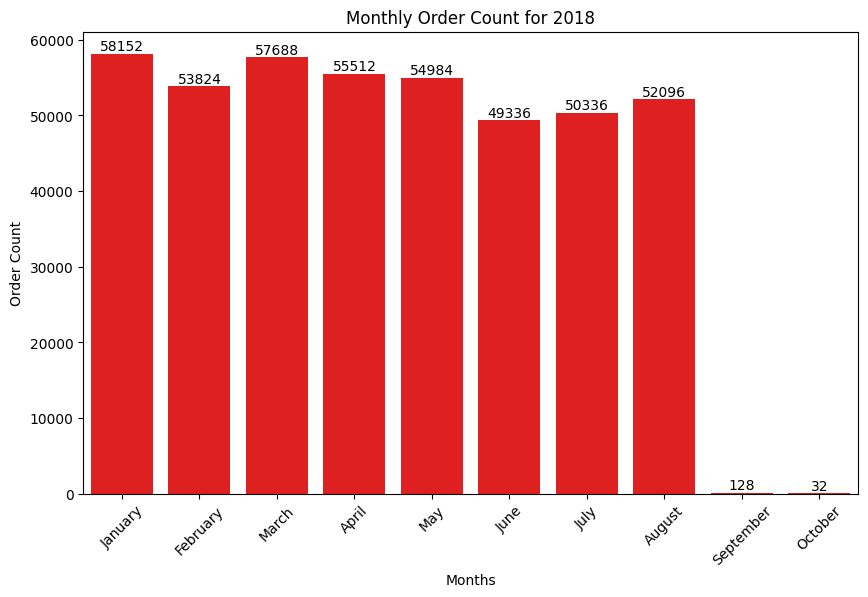

In [42]:
query = """
select monthname(order_purchase_timestamp) as month, count(order_id) as order_count
from orders
where year(order_purchase_timestamp) = 2018
group by month
"""

cur.execute(query)
data = cur.fetchall()
# Creating DataFrame with the fetched data
df = pd.DataFrame(data, columns=["Month", "Order_Count"])

# Debugging: Print the DataFrame to verify its structure
df
# Plotting the bar chart with Seaborn
plt.figure(figsize=(10, 6))
o=["January", "February", "March", "April", "May", "June", "July", "August", "September", "October"]
ax = sns.barplot(x='Month', y='Order_Count', data=df,order = o, color = "red")

ax.bar_label(ax.containers[0])
plt.xlabel('Months')
plt.ylabel('Order Count')
plt.title('Monthly Order Count for 2018')
plt.xticks(rotation=45)
plt.savefig("customers_per_state.png", bbox_inches='tight')
plt.show()

# Find the average number of products per order, grouped by customer city.

In [13]:
query= """with count_per_order as (
select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id
)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders 
from customers join count_per_order 
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_city", "average_products/order"])
df.head(10)

,customer_city,average_order
0,sao benedito do rio preto,32.00
1,serranopolis,32.00
2,brotas de macaubas,32.00
3,tunapolis,32.00
4,capela do alto alegre,32.00
5,fortim,32.00
6,cairu,32.00
7,epitaciolandia,32.00
8,urucania,32.00
9,porto calvo,32.00


# Calculate the percentage of total revenue contributed by each product category.

In [9]:
query = """
SELECT 
    UPPER(products.product_category) AS category, 
   round((SUM(payments.payment_value) / (SELECT SUM(payment_value) FROM payments)) * 100,2) AS sales_percentage
FROM products 
JOIN order_items ON products.product_id = order_items.product_id
JOIN payments ON payments.order_id = order_items.order_id
GROUP BY category order by sales_percentage desc
"""
cur.execute(query)
data = cur.fetchall()

df= pd.DataFrame(data, columns = ["Category", "Percentage distribution"])
df.head()


,Category,Percentage distribution
0,BED TABLE BATH,171.16
1,HEALTH BEAUTY,165.65
2,COMPUTER ACCESSORIES,158.45
3,FURNITURE DECORATION,142.94
4,WATCHES PRESENT,142.84


#  Identify the correlation between product price and the number of times a product has been purchased.

In [16]:
import pandas as pd
import mysql.connector

# Establishing the connection to the database
conn = mysql.connector.connect(
    host= "localhost",
    user="root",
    password="7F*q&654",
    database="ecommerce"
)
cur = conn.cursor()


# Writing the corrected SQL query
query = """
SELECT 
    products.product_category, 
    COUNT(order_items.product_id) AS order_count,
    ROUND(AVG(order_items.price), 2) AS average_price
FROM 
    products 
JOIN 
    order_items 
ON 
    products.product_id = order_items.product_id
GROUP BY 
    products.product_category;
"""

try:
    cur.execute(query)
    data = cur.fetchall()
    df = pd.DataFrame(data, columns=["Product_category", "Order_count", "Average_price"])
    print(df)  # This will display the DataFrame
except mysql.connector.Error as err:
    print(f"Error: {err}")

cur.close()
conn.close()


                   Product_category  Order_count  Average_price
0                     HEALTH BEAUTY       154720         130.16
1                     sport leisure       138256         114.34
2                        Cool Stuff        60736         167.36
3              computer accessories       125232         116.51
4                   Watches present        95856         201.14
..                              ...          ...            ...
69  Kitchen portable and food coach          240         264.57
70                  House Comfort 2          480          25.34
71       CITTE AND UPHACK FURNITURE          608         114.95
72           insurance and services           32         141.64
73                   cds music dvds          224          52.14

[74 rows x 3 columns]


# Calculate the total revenue generated by each seller, and rank them by revenue.


In [22]:
import pandas as pd
import mysql.connector

# Establishing the connection to the database
conn = mysql.connector.connect(
    host= "localhost",
    user="root",
    password="7F*q&654",
    database="ecommerce"
)
cur = conn.cursor()

# Writing the SQL query
query = """
SELECT 
    sellers.seller_id, 
    sellers.seller_city, 
    SUM(order_items.price) AS total_revenue
FROM 
    sellers
JOIN 
    order_items 
ON 
    sellers.seller_id = order_items.seller_id
GROUP BY 
    sellers.seller_id, 
    sellers.seller_city
ORDER BY 
    total_revenue DESC;
"""

try:
    cur.execute(query)
    data = cur.fetchall()
    df = pd.DataFrame(data, columns=["Seller_ID", "Seller_CITY", "Total_Revenue"])
    print(df)  # This will display the DataFrame
except mysql.connector.Error as err:
    print(f"Error: {err}")

cur.close()
conn.close()


                             Seller_ID       Seller_CITY  Total_Revenue
0     4869f7a5dfa277a7dca6462dcf3b52b2           guariba   3.671562e+06
1     53243585a1d6dc2643021fd1853d8905  lauro de freitas   3.564417e+06
2     4a3ca9315b744ce9f8e9374361493884          ibitinga   3.207567e+06
3     fa1c13f2614d7b5c4749cbc52fecda94            sumare   3.104672e+06
4     7c67e1448b00f6e969d365cea6b010ab   itaquaquecetuba   3.006782e+06
...                                ...               ...            ...
3090  34aefe746cd81b7f3b23253ea28bef39          curitiba   1.280000e+02
3091  702835e4b785b67a084280efca355756      juiz de fora   1.216000e+02
3092  1fa2d3def6adfa70e58c276bb64fe5bb         sao paulo   1.104000e+02
3093  77128dec4bec4878c37ab7d6169d6f26         sao paulo   1.040000e+02
3094  cf6f6bc4df3999b9c6440f124fb2f687         sao paulo   5.600000e+01

[3095 rows x 3 columns]
